In [1]:
# Data access
import requests
from sodapy import Socrata

# Data handling
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import dill 
from dateutil.parser import parse

# Data viz
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")
import seaborn as sns
import missingno as msno

# Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
import shap

# Interactive dropdown menus
import ipywidgets as widgets
from IPython.display import display

# Simplify warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [2]:
%load_ext lab_black

# Data preparation

## Load data

CDC's [COVID-19 case surveillance system database](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf) has over 3 million COVID-19 patients' demographic (e.g., sex, age group) and clinical (e.g., medical condition) information along with their treatment outcomes (e.g., whether they were hospitalized, stayed in ICU, and died). CDC provides an [API](https://dev.socrata.com/foundry/data.cdc.gov/vbim-akqf) with which we can access the latest data.

In [3]:
# Authenticated client
client = Socrata("data.cdc.gov", "wN4q7Cd3gBThmCSxEPDlCzFjw")

# Set limit to 10 million to get all records
results = client.get("vbim-akqf", limit=int(1e7))

# Save results as a dataframe
df_cases = pd.DataFrame.from_records(results)

In [4]:
# Pickle the dataframe
dill.dump(df_cases, open("cases.pkl", mode="wb"))

In [5]:
# How many patients?
print(f"Currently {df_cases.shape[0]} patients in COVID-19 case surveillance database.")

Currently 3662325 patients in COVID-19 case surveillance database.


## Clean data

### Select columns

Given my goal, I'm only keep columns related to patient conditions (sex, age group, race/ethnicity, medical condition) and treatment outcomes (hospitalized, ICU, death).

In [6]:
# Select columns to keep
to_keep = [
    "sex",
    "age_group",
    "race_ethnicity_combined",
    "medcond_yn",
    "hosp_yn",
    "icu_yn",
    "death_yn",
]

df_outcomes = df_cases[to_keep]

### Missing values

Missing values in this dataset are labeled as "Missing", "Unknown", or "NA", which I'll recode as `np.nan`.

In [7]:
df_outcomes = df_outcomes.replace(["Missing", "Unknown", "NA"], np.nan)

In the case of biological sex, we may need to code "Other" as missing since there are too few cases to make reliable predictions.

In [8]:
df_outcomes["sex"].replace("Other", np.nan, inplace=True)

### Target and features
In this project, the target of prediction is each patient's treatment outcome, which we can put into 3 categories:
1. Mild (0): `hosp_yn == "No"` and `icu_yn != "Yes"` and `death_yn != "Yes"`
2. Moderate (1): `hosp_yn == "Yes"` and `icu_yn != "Yes"` and `death_yn != "Yes"` 
3. Severe (2): `icu_yn == "Yes"` or `death_yn == "Yes"`

In [9]:
def label_outcome(row):
    if row["hosp_yn"] == "No" and row["icu_yn"] != "Yes" and row["death_yn"] != "Yes":
        return int(0)
    if row["hosp_yn"] == "Yes" and row["icu_yn"] != "Yes" and row["death_yn"] != "Yes":
        return int(1)
    if row["icu_yn"] == "Yes" or row["death_yn"] == "Yes":
        return int(2)
    return np.nan

In [10]:
df_outcomes["outcome"] = df_outcomes.apply(lambda row: label_outcome(row), axis=1)

Through trial and error, however, I noticed that "moderate" is hard to predict. To improve model performance, I'll group "mild" and "moderate" together as "not_severe" (0), as opposed to "severe" (1).

In [11]:
# Drop patients w/o outcome info
df_outcomes.dropna(subset=["outcome"], inplace=True)

# Recode outcomes
df_outcomes["outcome"].replace({0.0: 0, 1.0: 0, 2.0: 1}, inplace=True)

Other variables are features we can use to predict outcomes. Let's create `X` and `y` to store our features and target.

In [12]:
X = df_outcomes[["sex", "age_group", "race_ethnicity_combined", "medcond_yn"]]
y = df_outcomes["outcome"]

### One-hot encoding 
Let's one-hot encode categorical features. For binary features, we can keep just one column. Before that, we can simplify category labels and feature names to avoid long variable names resulted from one-hot encoding.

In [13]:
# Simplify race/enthnicity labels
race_dict = {
    "White, Non-Hispanic": "white",
    "Hispanic/Latino": "hispanic",
    "Black, Non-Hispanic": "black",
    "Multiple/Other, Non-Hispanic": "multi",
    "Asian, Non-Hispanic": "asian",
    "American Indian/Alaska Native, Non-Hispanic": "native",
    "Native Hawaiian/Other Pacific Islander, Non-Hispanic": "pacific",
}

X["race_ethnicity_combined"].replace(race_dict, inplace=True)

In [14]:
# Simplify age group labels (80+ capped at 99)
age_dict = {
    "0 - 9 Years": "0_9",
    "10 - 19 Years": "10_19",
    "20 - 29 Years": "20_29",
    "30 - 39 Years": "30_39",
    "40 - 49 Years": "40_49",
    "50 - 59 Years": "50_59",
    "60 - 69 Years": "60_69",
    "70 - 79 Years": "70_79",
    "80+ Years": "80_99",
}

X["age_group"].replace(age_dict, inplace=True)

In [15]:
# Also simplify feature names
X.rename(
    columns={"race_ethnicity_combined": "race", "medcond_yn": "medcond"}, inplace=True
)

In [16]:
# One-hot encoding
X = pd.get_dummies(X)

# Only keep "medcond_Yes" and "sex_Male"
X.drop(["medcond_No"], axis=1, inplace=True)
X.drop(["sex_Female"], axis=1, inplace=True)

# Model training

## Train/test/validation split

To avoid data leakage, I'll split the data into 3 sets: 60% train, 20% validation, and 20% test. The validation set is used to tune hyperparameters, the train set is used to estimate specific parameters, and the test set is used to evaluate how well the model generalizes to unseen data.

In [17]:
# First split: 60% train + 40% other (validate + test)
X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [18]:
# Second split: 20% validate + 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other, test_size=0.5, random_state=42
)

## Resampling
Only a minority of COVID-19 patients experienced severe outcomes (death or ICU). Such class balance may bring down model performance. To address this concern, we can use techniques such as SMOTE to oversample the minority class(es).

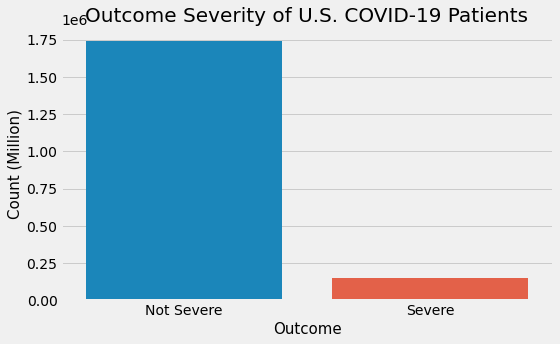

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="outcome", data=pd.DataFrame(y))
plt.xticks([0.0, 1.0], ["Not Severe", "Severe"])
plt.xlabel("Outcome", fontsize=15)
plt.ylabel("Count (Million)", fontsize=15)
plt.title("Outcome Severity of U.S. COVID-19 Patients", fontsize=20)
plt.tight_layout()
plt.savefig("outcome.png", dpi=300)

In [20]:
# Oversample minority classes in 3 sets
oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
X_val_os, y_val_os = oversample.fit_resample(X_val, y_val)
X_test_os, y_test_os = oversample.fit_resample(X_test, y_test)

## Hyperparamter tuning

Since around 2016, XGBoost is hailed as one of the most powerful algorithms for predictive modeling. Over the past few years, a conceptually similar yet substantially faster algorithm, [Light GBM](https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d), has been gaining popularity. Given the amount of patient data, I'll use Light GBM in this project to predict outcome severity.

XGBoost is notorious for having many hyperparamters and Light GBM has even more. Apparently, it's not practical to tune every single parameter so I'll focus on the [most important](https://neptune.ai/blog/lightgbm-parameters-guide) ones and tune these on the validation set.

In [21]:
# Hyperparameter space to search from
params = {
    "num_leaves": np.arange(10, 201),
    "max_depth": np.arange(1, 31),
    "learning_rate": np.arange(0.01, 0.51, 0.02),
    "feature_fraction": np.arange(0.1, 1.0, 0.1),
    "subsample": np.arange(0.1, 1.0, 0.1),
}

In [22]:
# Custom scorer using weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

In [23]:
# Search for best estimator using validation set
rs = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_distributions=params,
    scoring=scorer,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=1,
)

rs.fit(X_val_os, y_val_os)

best_clf = rs.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


## Model fitting

Now, let's use the best estimator found through randomized search above to fit training data.

In [24]:
# Refit tuned model on train set
best_clf.fit(X_train_os, y_train_os)

LGBMClassifier(feature_fraction=0.9, learning_rate=0.42999999999999994,
               max_depth=28, num_leaves=114, subsample=0.4)

In [25]:
# Use trained model to make predictions
y_train_pred = best_clf.predict(X_train_os)

In [26]:
# Compare predicted vs. actual outcomes
print(
    classification_report(
        y_train_os, y_train_pred, target_names=["not_severe", "severe"]
    )
)

              precision    recall  f1-score   support

  not_severe       0.83      0.79      0.81   1044851
      severe       0.80      0.83      0.82   1044851

    accuracy                           0.81   2089702
   macro avg       0.81      0.81      0.81   2089702
weighted avg       0.81      0.81      0.81   2089702



Text(0.5, 1.0, 'Confusion Matrix')

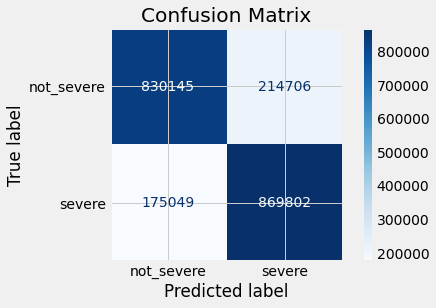

In [27]:
# Show confusion matrix
plot_confusion_matrix(
    best_clf,
    X_train_os,
    y_train_os,
    display_labels=["not_severe", "severe"],
    cmap=plt.cm.Blues,
    normalize=None,
)
plt.title("Confusion Matrix")

## Model evaluation

Finally, we can validate the trained model on the test set that we've never touched before.

In [28]:
# Use trained model to make predictions
y_pred = best_clf.predict(X_test_os)

In [29]:
# Compare predicted vs. actual outcomes
print(classification_report(y_test_os, y_pred, target_names=["not_severe", "severe"]))

              precision    recall  f1-score   support

  not_severe       0.83      0.79      0.81    348221
      severe       0.80      0.84      0.82    348221

    accuracy                           0.82    696442
   macro avg       0.82      0.82      0.81    696442
weighted avg       0.82      0.82      0.81    696442



Text(0.5, 1.0, 'Confusion Matrix')

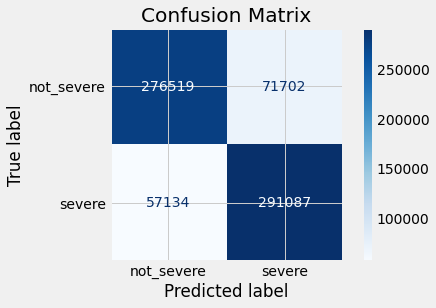

In [30]:
# Show confusion matrix
plot_confusion_matrix(
    best_clf,
    X_test_os,
    y_test_os,
    display_labels=["not_severe", "severe"],
    cmap=plt.cm.Blues,
    normalize=None,
)
plt.title("Confusion Matrix")

Since we don't have many features to begin with, the F1-scores (0.82 for "severe" and 0.81 for "not severe") of the Light GBM classifier are pretty decent. Moreover, these scores are almost identical in the test set and the train set, suggesting we're not overfitting, which is a common concern for these ensemble models.

In [31]:
# Save the trained model
dill.dump(best_clf, open("lgb_clf.pkl", "wb"))

## Feature importances
After building a predictive model, it's nice to have a sense which features contribute the most to predictions and in what way. [SHAP](https://github.com/slundberg/shap) is a modern, game-theoretic approach to measuring feature importances.

100%|===================| 34816/34822 [04:50<00:00]        

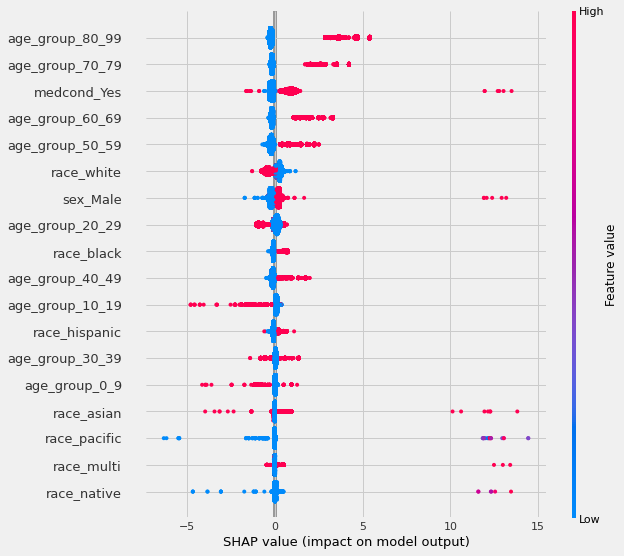

In [32]:
# Take a subset of test set, or it may take forever
subset = X_test_os.sample(frac=0.05, replace=True, random_state=1)

# Summarize the effects of all the features
shap.initjs()
background = X_train_os.iloc[0:100, :].values.astype("float")
explainer = shap.TreeExplainer(best_clf, background)
shap_values = explainer.shap_values(subset)
shap.summary_plot(shap_values, subset)

# Predict for new users

Before putting together a web app, let's create a prototype predictor for a hypothetical new user.

## Get user input
First, let's ask the user 4 questions that the model needs to a make prediction.

In [33]:
# Compile questions
sex = widgets.Dropdown(options=[("Male", 1), ("Female", 0)], description="Sex")

age_group = widgets.Dropdown(
    options=[
        ("0-9 Years", "0_9"),
        ("10-19 Years", "10_19"),
        ("20-29 Years", "20_29"),
        ("30-39 Years", "30_39"),
        ("40-49 Years", "40_49"),
        ("50-59 Years", "50_59"),
        ("60-69 Years", "60_69"),
        ("70-79 Years", "70_79"),
        ("80+ Years", "80_99"),
    ],
    layout={"width": "max-content"},
    description="Age Group",
)

race = widgets.Dropdown(
    options=[
        ("Asian, Non-Hispanic", "asian"),
        ("White, Non-Hispanic", "white"),
        ("Black, Non-Hispanic", "black"),
        ("Multiple/Other, Non-Hispanic", "multi"),
        ("Hispanic/Latino", "hispanic"),
        ("Native Hawaiian/Pacific Islander", "pacific"),
        ("American Indian/Alaska Native", "native"),
    ],
    layout={"width": "max-content"},
    description="Race",
)

medcond = widgets.Dropdown(
    options=[("Yes", 1), ("No", 0)],
    description="Medical Condition",
    layout={"width": "max-content"},
)

In [34]:
# Displace questions
display(sex)
display(age_group)
display(race)
display(medcond)

Dropdown(description='Sex', options=(('Male', 1), ('Female', 0)), value=1)

Dropdown(description='Age Group', layout=Layout(width='max-content'), options=(('0-9 Years', '0_9'), ('10-19 Y…

Dropdown(description='Race', layout=Layout(width='max-content'), options=(('Asian, Non-Hispanic', 'asian'), ('…

Dropdown(description='Medical Condition', layout=Layout(width='max-content'), options=(('Yes', 1), ('No', 0)),…

In [35]:
# Collect answers
user_sex = sex.value
user_age = age_group.value
user_race = race.value
user_medcond = medcond.value

## Clean input
Then let's wrangle this user's answers into a one-row dataframe with the same column names as our training data.

In [36]:
# Empty dataframe for new user
df_user = pd.DataFrame(columns=X.columns, index=[0])

In [37]:
# Fill in w/ user input
for col in df_user.columns:
    df_user[col] = 1 if (user_age in col or user_race in col) else 0

df_user["sex_Male"] = 1 if user_sex == 1 else 0

df_user["medcond_Yes"] = 1 if user_medcond == 1 else 0

## Make prediction
Finally, we can call our trained model to predict the user's outcome severity.

In [38]:
# Load model
with open("lgb_clf.pkl", "rb") as file:
    model = dill.load(file)

In [39]:
# Make prediction
new_pred = model.predict_proba(df_user)

print(
    "If contracted COVID-19, your probability of having severe outcome is {}%.".format(
        round(new_pred.tolist()[0][1] * 100, 2)
    )
)

If contracted COVID-19, your probability of having severe outcome is 1.33%.
